# Pipeline for the anomaly detection on the SKAB using Isolation Forest

Details regarding the SKAB one can find in the [SKAB repository](https://github.com/waico/SKAB).

## Libraries importing

In [1]:
# libraries importing
import sys
import warnings

import pandas as pd
from sklearn.model_selection import train_test_split

sys.path.append("..")
from core.Isolation_Forest import Isolation_Forest
from core.metrics import chp_score
from core.utils import plot_results

sys.path.append("../../odmd-subid-cpd")
from functions.datasets import load_cats

warnings.filterwarnings("ignore", category=UserWarning)

## Data

In [2]:
df = load_cats(
    file_path="/Users/mw/pyprojects/odmd-subid-cpd/examples/data/cats/data.csv",
    resample_s=60,
)
df = df.rename(columns={"y": "anomaly"})
X = df[
    [
        "bed1",
        "bed2",
        "bfo1",
        "bfo2",
        "bso1",
        "bso2",
        "bso3",
        "ced1",
        "cfo1",
        "cso1",
        "aimp",
        "amud",
        "adbr",
        "adfl",
    ]
]
Y = df[["anomaly", "category"]]
Xy_traintest_list = [
    train_test_split(
        X,
        Y,
        train_size=int(1e6 / 60),
        shuffle=False,
        random_state=0,
    )
]

## Method

### Method initialization

In [11]:
# hyperparameters selection
random_state = 0
n_jobs = -1
contamination = 0.038
PARAMS = [random_state, n_jobs, contamination]

In [12]:
# model defining
model = Isolation_Forest(PARAMS)

### Method fitting and applying

In [13]:
# inference
predicted_outlier, predicted_cp = [], []
true_outlier, true_cp = [], []
for X_train, X_test, y_train, y_test in Xy_traintest_list:
    # classifier fitting
    model.fit(X_train)

    # results predicting
    prediction = (
        pd.Series(
            model.predict(X_test) * -1,
            index=X_test.index,
        )
        .rolling(3)
        .median()
        .fillna(0)
        .replace(-1, 0)
    )

    # predicted outliers saving
    predicted_outlier.append(prediction)

    # predicted CPs saving
    prediction_cp = prediction.rolling(30).max().fillna(0).diff().abs()
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

    true_outlier.append(y_test["anomaly"])
    true_cp.append(y_test["anomaly"].diff().abs().fillna(0.0))

### Results visualization

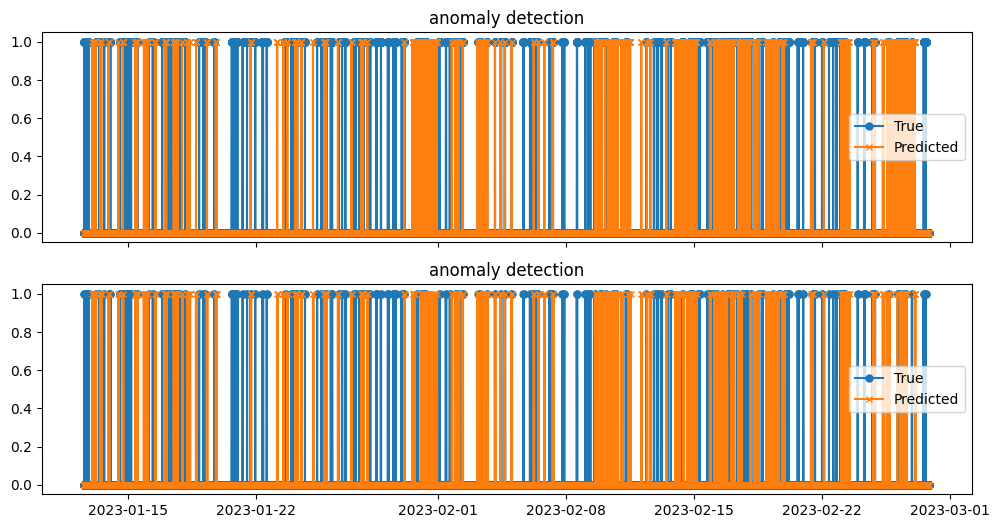

In [14]:
# [donotremove]
plot_results(
    (true_outlier[0], predicted_outlier[0]),
    (true_cp[0], predicted_cp[0]),
)

## Evaluation (metrics calculation)

In [15]:
import pickle

pickle.dump(
    predicted_outlier,
    open(f"../results/results-cats-{model.__class__.__name__}.pkl", "wb"),
)

### Binary classification (outlier detection) metrics

In [16]:
# [donotremove]
# binary classification metrics calculation
binary = chp_score(true_outlier, predicted_outlier, metric="binary")

False Alarm Rate 7.02 %
Missing Alarm Rate 83.36 %
F1 metric 0.13


### Changepoint detection metrics

In [17]:
# [donotremove]
# average detection delay metric calculation
add = chp_score(
    true_cp,
    predicted_cp,
    metric="average_time",
    window_width="18000s",
    anomaly_window_destination="righter",
)

Amount of true anomalies 398
A number of missed CPs = 301
A number of FPs = 106
Average time 0 days 01:24:12.989690721


In [18]:
# [donotremove]
# nab metric calculation
nab = chp_score(
    true_cp,
    predicted_cp,
    metric="nab",
    window_width="18000s",
    anomaly_window_destination="righter",
)

Standard  -  17.81
LowFP  -  15.84
LowFN  -  20.0
